# Fitting phenomenological models to 21-cm power spectra

This notebook shows how to fit 21-cm power spectra with the [micro21cm](https://github.com/mirochaj/micro21cm) code using [pspec_likelihood](https://github.com/HERA-Team/pspec_likelihood) to handle the likelihood and [emcee](https://emcee.readthedocs.io/en/stable/) to do the MCMC sampling. Here, we'll fit some made-up data, but it should be clear how to swap in whatever dataset you like. 

To begin, a bunch of imports:

In [1]:
%matplotlib inline

In [2]:
# usual stuff
import numpy as np
import matplotlib.pyplot as plt

# astropy stuff
from astropy import cosmology
from astropy import units as un

# 21-cm stuff
import pspec_likelihood as pslike
import micro21cm

# Other
import os
import time
import h5py
import emcee
import pickle

## Define theory model

The phenomenological model being used here works directly in terms of IGM properties. At a single redshift, its free parameters are (i) the global ionized fraction, $Q$, i.e., the volume-filling fraction of ionized gas, (ii) the spin temperature in the "bulk IGM" outside bubbles, $T_S$, (iii) the characteristic bubble size, $R$, and (iv) the dispersion in the bubble size distribution, $\sigma$, which we'll assume here follows a log-normal distribution. For more details, check out the [paper](https://ui.adsabs.harvard.edu/abs/2022MNRAS.514.2010M/abstract).

In this notebook, we'll fit a multi-epoch dataset, so how we parameterize the ionization and temperature *histories* is up to us. For simplicity, we'll do the following:

- Parameterize $Q(z)$ as a power-law with a maximum value of 1.
- Take $T(z)$ as a sum of power laws, one with a positive slope (heating epoch) and one with a negative slope (for high-z cooling). 
- Assume the typical bubble size is a power-law in $Q$.
- Take $\sigma$ to be independent of redshift.

This results in a total of 9 free parameters. This parameterization is flexible enough to produce arbitrarily low temperatures, but if you want to restrict yourself to $\Lambda$CDM, you can easily institute a "floor" in the temperature.

#### Make a `micro21cm.BubbleModel` instance to do the heavy lifting

We'll pass in an `astropy.cosmology.Planck18` instance for consistency with the `DataModelInterface` below, and turn off verbosity:

In [3]:
_model = micro21cm.BubbleModel(bubbles_pdf='lognormal', 
    cosmology=cosmology.Planck18, verbose=False)

#### Make functions to handle $Q(z)$, $T_S(z)$, etc.

In [4]:
def power_law(z, pars):
    return pars[0] * ((1 + z) / 8.)**pars[1]

def get_Ts(z, pars):
    """
    Compute the spin temperature as a sum of heating and cooling:
    
        Ts = Tadiabatic * p0 * ((1 + z) / 8)**p1 
           + 10**p2 * ((1 + z) / 8)**p3 
    
    .. note :: The third parameter, pars[2], is log10(Ts(z=8)), hence
        the 10**pars[2] factor below.
        
    .. note :: The pars[0] == 1 and pars[1] == 2 case is adiabatic cooling, 
        and effectively assumes WF coupling is complete, Ts == Tk.

    """
    cooling = _model.get_Tgas(z) * power_law(z, pars[0:2])
    heating = power_law(z, [10**pars[2], pars[3]])
    
    return cooling + heating

def get_R(Q, pars):
    """ Assume the characteristic bubble size is a power-law in the ionized fraction. """
    return pars[0] * (Q / 0.5)**pars[1]

def get_Q(z, pars):
    """ Assume the ionized fraction evolution is a power-law capped at unity. """
    return np.minimum(0.999999, power_law(z, pars))

class BubbleModel(object):
    """
    This is basically a wrapper around micro21cm's `get_ps_21cm` method -- we just 
    have to unpack the list of parameters, compute Ts(z), Q(z), and R(Q). Also, 
    we cache the power spectrum so that we can save it for inspection in post 
    processing.
    """
    def __init__(self):
        self._cache = {}
    
    def __call__(self, z: float, k: np.ndarray, params: list[float]) -> np.ndarray:
        
        # Look to see if we generated this realization already. If so, load it.
        if (z, tuple(params)) in self._cache:
            return self._cache[(z, tuple(params))]
        
        
        # Unpack parameters
        Q0, Q1, Ts0, Ts1, Ts2, Ts3, R0, R1, sigma = params
    
        # Generate Q, R, Ts at requested redshift.
        Q = get_Q(z, [Q0, Q1])
        R = get_R(Q, [R0, R1])
        Ts = get_Ts(z, [Ts0, Ts1, Ts2, Ts3])
    
        # Call micro21cm, which returns P(k)
        pofk = _model.get_ps_21cm(z=z, k=np.array(k), Q=Q, Ts=Ts, R=R, sigma=sigma)
    
        # Convert to dimensionless power spectrum and bestow with units
        dsq = k**3 / (2*np.pi**2) * pofk * un.mK**2
        
        # Save this power spectrum so we can grab it for free later
        self._cache[(z, tuple(params))] = dsq
                
        return dsq
    
    def clear_cache(self):
        self._cache = {}
        
##
# Instance of the modeling class
theory_model = BubbleModel()    

### Show a few example histories

Just to get a feel for what the adopted $Q(z)$, $T_S(z)$, and $R(z)$ models yield, here are a few examples. This should give an idea for how, e.g., power-law indices for $Q$ and $T_S$ translate to the kind of reionization and thermal histories we're used to seeing from physical models.

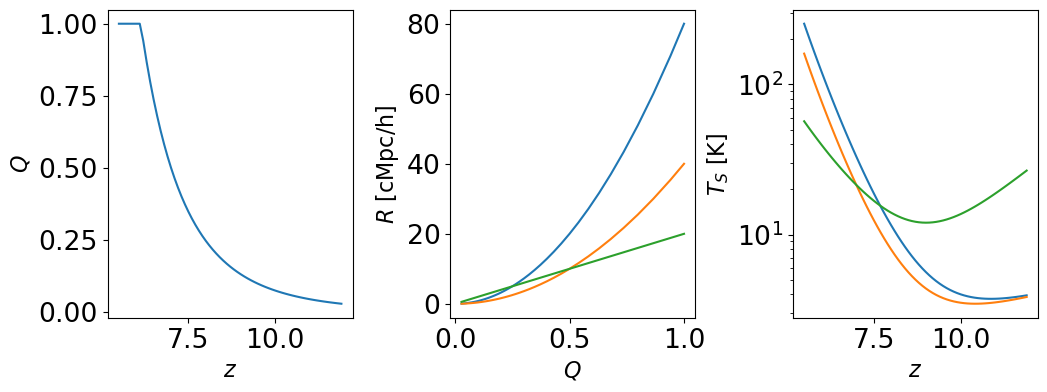

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

zarr = np.arange(5.5, 12, 0.1)

# Reionization 50% complete at z=8
Q = get_Q(zarr, [0.5, -6])

axes[0].plot(zarr, Q)
axes[1].plot(Q, get_R(Q, [20, 2]))
axes[1].plot(Q, get_R(Q, [10, 2]))
axes[1].plot(Q, get_R(Q, [10, 1]))
axes[2].semilogy(zarr, get_Ts(zarr, [1, 0, 1.5, -10]))
axes[2].semilogy(zarr, get_Ts(zarr, [1, 0, 1.3, -10]))
axes[2].semilogy(zarr, get_Ts(zarr, [1, 4, 1.3, -5]))

# Labels etc.
axes[0].set_xlabel(r'$z$') 
axes[0].set_ylabel(r'$Q$') 
axes[1].set_xlabel(r'$Q$') 
axes[1].set_ylabel(r'$R \ [\rm{cMpc} / h]$') 
axes[2].set_xlabel(r'$z$') 
axes[2].set_ylabel(r'$T_S \ [\rm{K}]$')
fig.subplots_adjust(wspace=0.4)

## Make-up some data

For simplicity, here we'll just take a `micro21cm` model as the truth, and add constant errors. Hopefully it's clear how to generalize this to more realistic scenarios.

In [6]:
# Somewhat arbitrary set of bands [in MHz]
bands_to_fit = 155, 165, 175, 185

# Only a few modes per band speeds things up.
# (micro21cm compute time scales as number of modes x number of bands)
k = 10**np.arange(-1, 0.2, 0.2)

model_pars_in = [0.6, -6, 1, 0, 1.8, -8, 20, 2, 1.5]

# Assemble a dictionary with each element containing the data for
# a single band.
data = {}
for band in bands_to_fit:
    data[band] = {}
    
    z = 1420.4057 / band - 1
    Dsq = theory_model(z, k, model_pars_in)
    
    data[band]['z'] = z          
    data[band]['k'] = k * cosmology.units.littleh / un.Mpc
    data[band]['covariance'] = 10. * np.eye(len(k)) * un.mK**4
    data[band]['window_function'] = np.eye(len(k))
    data[band]['power'] = Dsq

### Check that data look OK, plot a few example models

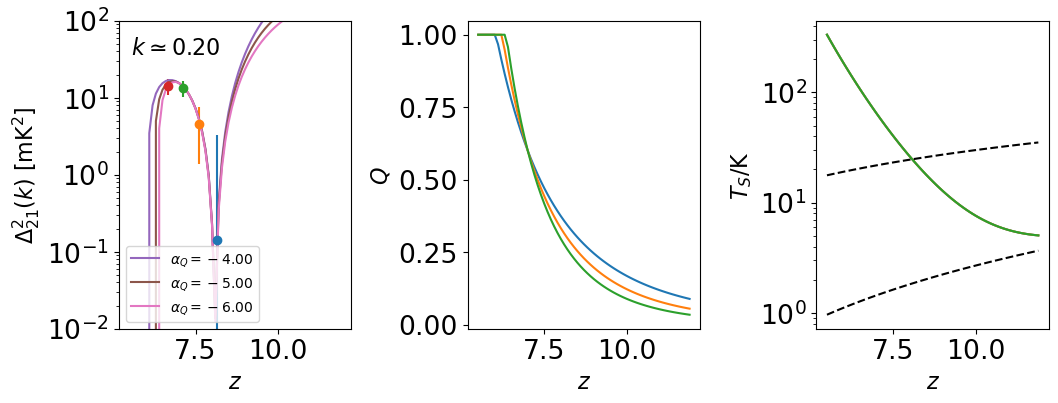

In [7]:
# Let's plot the evolution of the power spectrum at fixed k
kplot = 0.2

# Plot the power spectrum along with Q(z) and Ts(z) for reference
fig, (ax21, axQ, axT) = plt.subplots(1, 3, figsize=(12,4))    

# First, the mock data
for band in bands_to_fit:
    
    # Read in k, Delta^2, errors
    k = data[band]['k']
    power = data[band]['power']
    covariance = data[band]['covariance']
    covariance[np.isinf(covariance)] = 0
    err = np.sqrt(np.diag(covariance))
    
    # Isolate k~0.2 bin, plot vs. z
    ik = np.argmin(np.abs(kplot * cosmology.units.littleh / un.Mpc - k))
    
    ax21.errorbar(data[band]['z'], power[ik], yerr=err[ik], fmt='o')

# Make an array of redshifts that will yield smoother curves for the models
zall = np.arange(5.5, 12, 0.1)
       
# Now, plot a few models, vary the speed of reionization
for Q1 in [-4, -5, -6]:
    params = [0.6, Q1, 1, 0, 1.8, -8, 20, 2, 1.5]
        
    # Generate Q, R, Ts at requested redshift.
    Q = get_Q(zall, params[0:2])
    R = get_R(Q, params[6:8])
    Ts = get_Ts(zall, params[2:6])
    
    # Taking units out cuz I don't understand astropy :(
    power = [theory_model(_z_, kplot, params) / un.mK**2 \
        for _z_ in zall]
        
    ax21.semilogy(zall, power, ls='-', label=r'$\alpha_Q = %.2f$' % Q1)
    axQ.plot(zall, Q)
    axT.semilogy(zall, Ts)
    
    theory_model.clear_cache()
    
    
ax21.set_xscale('linear')
ax21.set_yscale('log')
ax21.set_xlabel(r'$z$')
ax21.set_ylabel(r'$\Delta_{21}^2(k) \ [\rm{mK}^2]$')
ax21.legend(loc='lower left', fontsize=10)
ax21.annotate(r'$k \simeq %.2f$' % kplot, (0.05, 0.95), xycoords='axes fraction',
    va='top', ha='left')

ax21.set_ylim(1e-2, 100)
axQ.set_xlabel(r'$z$')
axQ.set_ylabel(r'$Q$')
axT.set_xlabel(r'$z$')
axT.set_ylabel(r'$T_S/\rm{K}$')
axT.semilogy(zarr, _model.get_Tgas(zarr), color='k', ls='--')
axT.semilogy(zarr, _model.get_Tcmb(zarr), color='k', ls='--')

fig.subplots_adjust(wspace=0.5)

## Create likelihood(s)

In [8]:
all_dmi = []
for band in bands_to_fit:
    dmi = pslike.DataModelInterface(
        cosmology=cosmology.Planck18,
        redshift=data[band]['z'],
        power_spectrum=data[band]['power'],
        window_function=data[band]['window_function'],
        covariance=data[band]['covariance'],
        kpar_bins_obs=data[band]['k'],
        theory_uses_little_h=True,
        theory_uses_spherical_k=True,
        theory_model=theory_model,
    )
    all_dmi.append(dmi)

In [9]:
# Make a list of likelihoods -- one for each band.
like = [pslike.Gaussian(model=dmi) for dmi in all_dmi]

### Plot likelihood in each band for sanity check

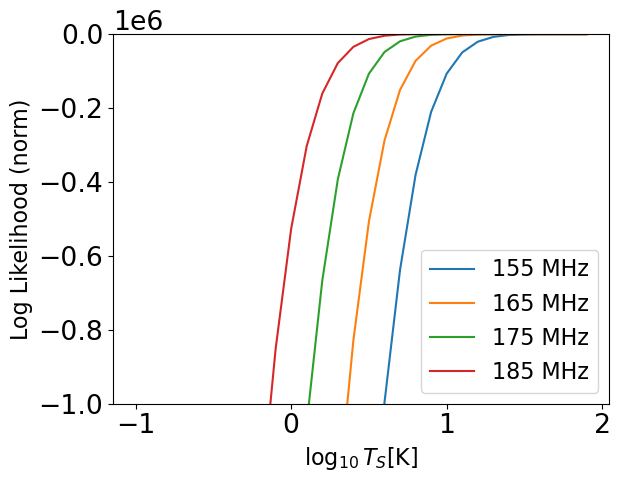

In [10]:
# Hold all parameters constant except temperature normalization
Ts = np.arange(-1, 2., 0.1)

for i, _like_ in enumerate(like):
    likes = np.array([_like_.loglike([0.6, -2, 1, 0, logT, -8, 20, 2, 1.5], None) for logT in Ts])
    plt.plot(Ts, likes - likes.max(), label=f'{bands_to_fit[i]} MHz')
    theory_model.clear_cache()
    
plt.ylim(-1000000, 0)
plt.xlabel(r"$\log_{10}T_S [\rm{K}]$")
plt.ylabel("Log Likelihood (norm)")
plt.legend()

## Setup an MCMC fit

First we'll write a function that returns the posterior, which is just looping over the bands, summing the likelihood, and asserting some broad priors on the model parameters. Then, we'll setup an `emcee.EnsembleSampler` object and run the fit.

In [11]:
null_blobs = [np.inf * np.ones_like(data[band]['k']) for band in bands_to_fit]

def lnprior(args):
    """ Assess the prior. """
    
    # Unpack model parameters
    Q0, Q1, T0, T1, T2, T3, R0, R1, s = args 
    
    # A bunch of broad priors below.
    # Key points: reionization occurs monotonically, 
    # bubbles grow with ionized fraction.
    if not (0 <= Q0 <= 1):
        return -np.inf, null_blobs
    
    if not (-20 <= Q1 < 0):
        return -np.inf, null_blobs
    
    if not (0 <= T0 <= 10):
        return -np.inf, null_blobs
    
    if not (0 <= T1 <= 20):
        return -np.inf, null_blobs
    
    # flat in log10(Ts) up to 10^3 K
    if not (0 <= T2 <= 3):
        return -np.inf, null_blobs
    
    if not (-20 <= T3 < 0):
        return -np.inf, null_blobs
    
    if not (0 <= R0 <= 50):
        return -np.inf, null_blobs
    
    if not (0 < R1 <= 10):
        return -np.inf, null_blobs
    
    if not (0.2 <= s <= 2.5):
        return -np.inf, null_blobs
    
    return 0.0, null_blobs

def lnpost(args):
    """
    Compute posterior probability for model described by given parameters.
    """
    
    lnP, _blobs = lnprior(args)
    
    if not np.isfinite(lnP):
        return -np.inf, null_blobs
    
    # Sum the log-likelihood from all the bands
    lnL = 0.0
    blobs = []
    for i, _like_ in enumerate(like):
        
        # The second argument is for systematics parameters, not using that here.
        _lnL = _like_.loglike(args, None)
        lnL += _lnL
        
        # Save the PS
        
        # First, figure out redshift for this band
        z = data[bands_to_fit[i]]['z']
        k = data[bands_to_fit[i]]['k']
        # Read result from cache
        _blobs = theory_model(z, k, args)

        blobs.append(_blobs)
        
    # The models will cache so we can save them as blobs without re-computing.
    # Clearing it out keeps memory consumpsion from growing out of control
    theory_model.clear_cache()
    
    # This is a safeguard against numerical problems 
    # that occur in tough corners of parameter space.
    if np.any(np.isnan(lnL)):
        return -np.inf, null_blobs
        
    return lnL, blobs

In the next cell, we set the initial walker positions, or if a file is found, we try to restart from the final step of the previous output. So, if you "Restart and Run All" this notebook, it will automatically augment the MCMC chain and update the plots with the full dataset. If you haven't changed anything, the following setup with 128 walkers and 10 steps (per walker) should run in about 10 minutes on a single core. The results won't be converged, but should give a rough sense of things.

In [12]:
# Some fit setup. 
fn_save = 'example_fit_micro21cm.pkl'
nwalkers = 128
nsteps = 10

# Check for previous run, can augment instead of starting from scratch.
# Note: number of walkers must be the same. No check for that yet.
if not os.path.exists(fn_save):
    
    data_pre = None

    # Set initial walker position for each parameter
    Q0 = np.random.rand(nwalkers)
    Q1 = -8 + np.random.rand(nwalkers) * 2
    T0 = np.random.rand(nwalkers) * 0.1 + 0.95
    T1 = np.random.rand(nwalkers) * 0.1
    T2 = np.random.rand(nwalkers) * 3
    T3 = -15 + np.random.rand(nwalkers) * 10
    R0 = 10 + np.random.rand(nwalkers) * 20
    R1 = 2 + np.random.rand(nwalkers) * 2
    s0 = 1.5 + np.random.rand(nwalkers) * 0.5

    # Form 2-d representation for initial walker positions
    pos = np.vstack([Q0, Q1, T0, T1, T2, T3, R0, R1, s0]).T
else:
    with open(fn_save, 'rb') as f:
        data_pre = pickle.load(f)
        
    pos = data_pre['chain'][:,-1,:]
    
    print(f"Restarting from previous output {fn_save}.")
    print(f"Found {data_pre['fchain'].shape[0]} samples there.")
    print(f"Will augment with {nsteps} more steps per walker.")

Restarting from previous output example_fit_micro21cm.pkl.
Found 11520 samples there.
Will augment with 10 more steps per walker.


In [13]:
# Make an EnsembleSampler to do the heavy lifting
sampler = emcee.EnsembleSampler(nwalkers, pos.shape[1], lnpost)

# Run the fit
t1 = time.time()
results = sampler.run_mcmc(pos, nsteps)
t2 = time.time()
print("Fit complete in {:.1f} minutes.".format((t2 - t1) / 60.))

# Grab basic data products
chain = sampler.chain
fchain = sampler.flatchain
blobs = sampler.blobs

# Save / augment data
with open(fn_save, 'wb') as f:
    if data_pre is None:
        out = {'chain': chain, 'fchain': fchain, 'blobs': blobs}
    else:
        out = {'chain': np.concatenate((data_pre['chain'], chain), axis=1),
               'fchain': np.concatenate((data_pre['fchain'], fchain)),
               'blobs': data_pre['blobs'] + blobs}
                
        chain = out['chain']
        fchain = out['fchain']
        blobs = out['blobs']
        
    pickle.dump(out, f)
        
print(f"Saved results to {fn_save}. {fchain.shape[0]} total samples.")

Fit complete in 8.8 minutes.
Saved results to example_fit_micro21cm.pkl. 12800 total samples.


## Plot some results

### First, posteriors for the model parameters

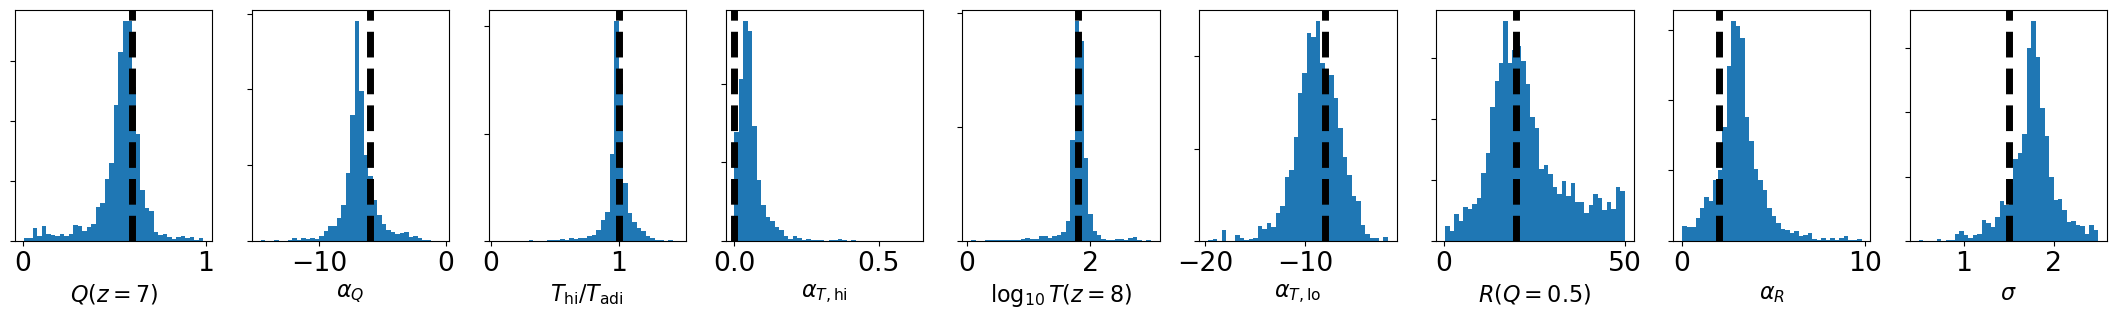

In [14]:
params_nice = [r'$Q(z=7)$', r'$\alpha_Q$', 
               r'$T_{\rm{hi}} / T_{\rm{adi}}$', r'$\alpha_{T,{\rm{hi}}}$', r'$\log_{10} T(z=8)$', r'$\alpha_{T,{\rm{lo}}}$', 
               r'$R(Q=0.5)$', r'$\alpha_R$', 
               r'$\sigma$']

fig, axes = plt.subplots(1, fchain.shape[1], figsize=(3*fchain.shape[1],3))

for i in range(fchain.shape[1]):
    axes[i].hist(fchain[:,i], bins=40)
    axes[i].set_xlabel(params_nice[i])
    axes[i].set_yticklabels([])
    axes[i].axvline(model_pars_in[i], color='k', lw=5, ls='--')

### Next, walker trajectories for fun

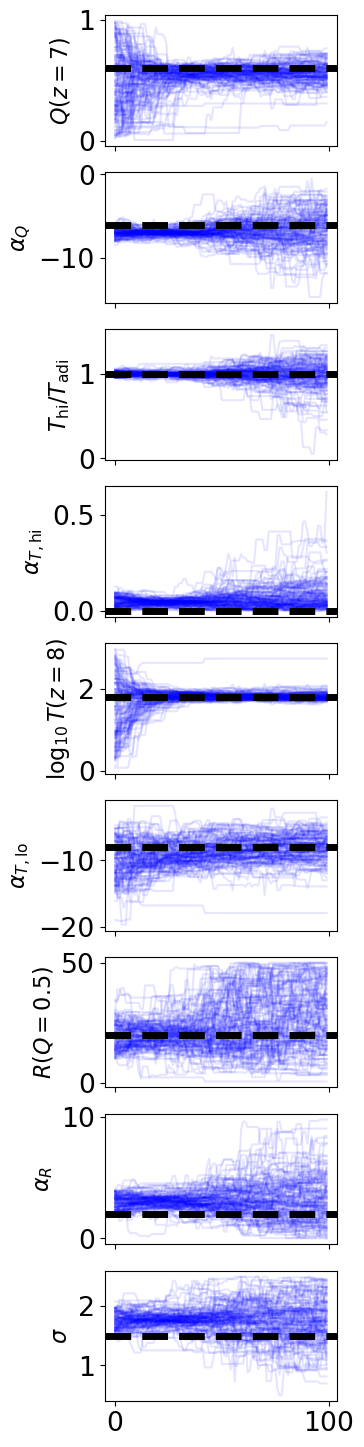

In [15]:
fig, axes = plt.subplots(fchain.shape[1], 1, figsize=(3,2*fchain.shape[1]))
for i in range(fchain.shape[1]):
    for j, walker in enumerate(range(nwalkers)):
        axes[i].plot(chain[j,:,i], color='b', alpha=0.1)
    
    axes[i].set_ylabel(params_nice[i])
    axes[i].axhline(model_pars_in[i], color='k', ls='--', lw=5)
    
    if i < fchain.shape[1] - 1:
        axes[i].set_xticklabels([])

### Next, reconstructed power spectrum, individual realizations

Text(0, 0.5, '$\\Delta_{21}^2(k) \\ [\\rm{mK}^2]$')

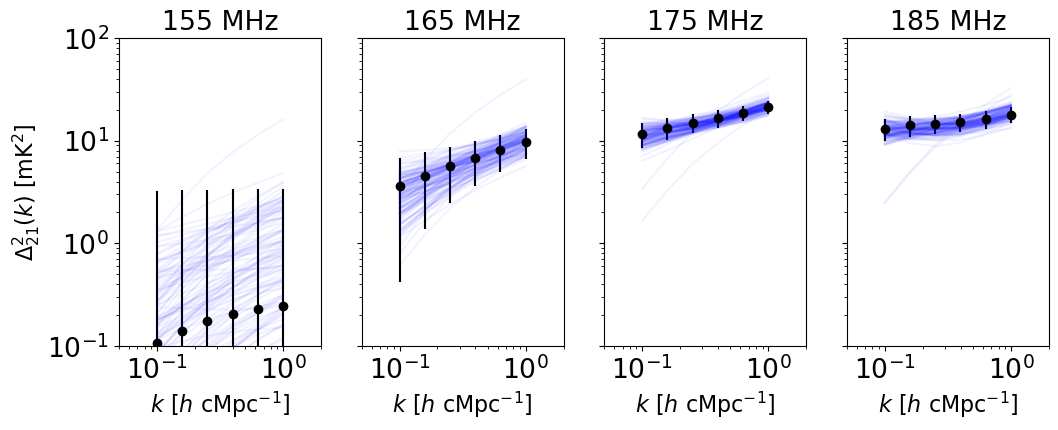

In [16]:
fig, axes = plt.subplots(1, len(bands_to_fit), figsize=(3*len(bands_to_fit), 4))

# blobs shape is (nsteps, nwalkers, number of bands, number of k modes)
for j, band in enumerate(bands_to_fit):
    
    axes[j].errorbar(data[band]['k'], data[band]['power'], fmt='o',
        yerr=np.sqrt(np.diag(data[band]['covariance'])), color='k')
    axes[j].set_title(f'{band} MHz')
    
    # Just plot current position of each walker
    for i, walker in enumerate(range(nwalkers)):
        axes[j].loglog(data[band]['k'], blobs[-1][i][j], color='b', alpha=0.05)
            
    axes[j].set_ylim(1e-1, 1e2)
    axes[j].set_xlim(5e-2, 2)
    axes[j].set_xlabel(r'$k \ [h \ \rm{cMpc}^{-1}]$')
    
    if j > 0:
        axes[j].set_yticklabels([])
    
axes[0].set_ylabel(r'$\Delta_{21}^2(k) \ [\rm{mK}^2]$')

### Show recovered Q(z), Ts(z)

In [17]:
# Reconstruct Q(z) and Ts(z) from chain
zall = np.arange(5.5, 12.1, 0.1)
Qrec = np.array([get_Q(zall, fchain[i,0:2]) \
    for i in range(int(fchain.shape[0]*0.8), fchain.shape[0])])
Trec = np.array([get_Ts(zall, fchain[i,2:6]) \
    for i in range(int(fchain.shape[0]*0.8), fchain.shape[0])])

In [18]:
# Construct the prior volume in Q(z) and Ts(z)
N = 100000
Q0 = np.random.rand(N)
Q1 = -np.random.rand(N) * 20
T0 = np.random.rand(N) * 10
T1 = np.random.rand(N) * 20
T2 = np.random.rand(N) * 3
T3 = -np.random.rand(N) * 20
R0 = np.random.rand(N) * 50
R1 = np.random.rand(N) * 10
s = np.random.rand(N) * 2.3 + 0.2

prior = np.array([Q0, Q1, T0, T1, T2, T3, R0, R1, s]).T

Qpri = np.array([get_Q(zall, prior[i,0:2]) for i in range(prior.shape[0])])
Tpri = np.array([get_Ts(zall, prior[i,2:6]) for i in range(prior.shape[0])])

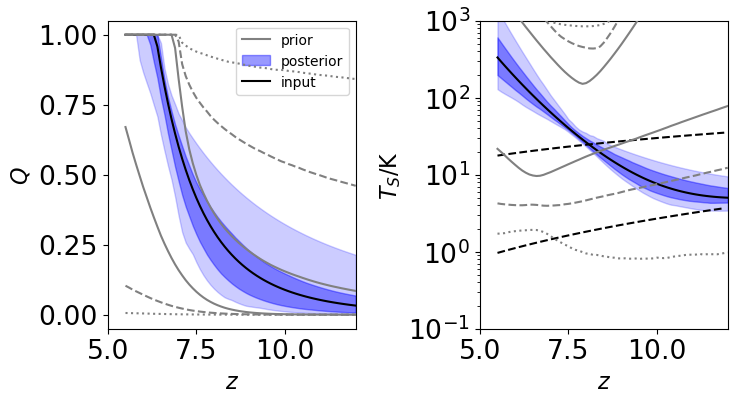

In [19]:
# Now, plot reconstructed Q(z) and Ts(z) vs. priors
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# First, the priors
for i, blob in enumerate([Qpri, Tpri]):
    
    # Compute 68 and 95% bands roughly
    lo68, hi68 = np.percentile(blob, (16, 84), axis=0)
    lo95, hi95 = np.percentile(blob, (2.5, 97.5), axis=0)
    lo99, hi99 = np.percentile(blob, (0.15, 99.85), axis=0)
    
    # Plot as shaded regions
    axes[i].plot(zall, lo99, color='gray', alpha=1, ls=':', zorder=1000)
    axes[i].plot(zall, hi99, color='gray', alpha=1, ls=':', zorder=1000)
    axes[i].plot(zall, lo95, color='gray', alpha=1, ls='--', zorder=1000)
    axes[i].plot(zall, hi95, color='gray', alpha=1, ls='--', zorder=1000)
    axes[i].plot(zall, lo68, color='gray', alpha=1, zorder=1000)
    axes[i].plot(zall, hi68, color='gray', alpha=1, zorder=1000, 
        label='prior' if i == 0 else None)

# Next, the reconstructed curves
for i, blob in enumerate([Qrec, Trec]):
    
    # Compute 68 and 95% bands roughly
    lo68, hi68 = np.percentile(blob, (16, 84), axis=0)
    lo95, hi95 = np.percentile(blob, (2.5, 97.5), axis=0)
    
    # Plot as shaded regions
    axes[i].fill_between(zall, lo95, hi95, color='b', alpha=0.2)
    axes[i].fill_between(zall, lo68, hi68, color='b', alpha=0.4,
        label='posterior' if i == 0 else None)
        
    axes[i].set_xlabel(r'$z$')
    axes[i].set_xlim(5, 12)
    

# Plot inputs
axes[0].plot(zall, get_Q(zall, model_pars_in[0:2]), color='k', label='input')
axes[1].plot(zall, get_Ts(zall, model_pars_in[2:6]), color='k')

# Adiabatic temperature and CMB for reference
axes[1].semilogy(zarr, _model.get_Tgas(zarr), color='k', ls='--')
axes[1].semilogy(zarr, _model.get_Tcmb(zarr), color='k', ls='--')

# Axes labels etc.
axes[0].set_ylabel(r'$Q$')
axes[1].set_ylabel(r'$T_S / \rm{K}$')
axes[1].set_yscale('log')
axes[0].legend(loc='upper right', fontsize=10, frameon=True)
axes[1].set_ylim(0.1, 1e3)
fig.subplots_adjust(wspace=0.5)